In [1]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from src.datagenerator import DataGenerator, DataLoader, z_score
from src.performance_evaluation import compute_PCA, plot_confusion_matrix, plot_PCA
from src.util import plot_voxel
# load vae model
from src.vae import vae_model

2024-04-24 06:20:42.001925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 06:20:45.367279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.__version__)

2.16.1


# Stage 2

**1. Training of the material classificator $\Upsilon$**

**2. Training of the mapper $\Xi$**

## Material classificator $\Upsilon$

### *i)* DNN

## *ii)* CNN

In [3]:
datagenerator = False

params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "supervised": "material",  # "diameter" or "material"
    "batch_size": 128,
    "shuffle": True,
    "EIT_shape": "matrix",
}

if datagenerator:

    idx = np.arange(0, len(os.listdir(params["path"])))
    np.random.shuffle(idx)

    limit_index = 100_000

    training_generator = DataGenerator(idx[:limit_index], **params)
    test_____generator = DataGenerator(idx[limit_index:], **params)
    X, Y = training_generator[0]
else:
    X, Y = DataLoader(params)
    X = z_score(X)
    X = np.expand_dims(X, axis=3)
    print(X.shape, Y.shape)

100%|██████████| 124200/124200 [44:37<00:00, 46.38it/s] 


(124200, 64, 64, 1) (124200,)


In [100]:
print(X.shape, Y.shape)

(124200, 64, 64, 1) (124200,)


In [101]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42
)

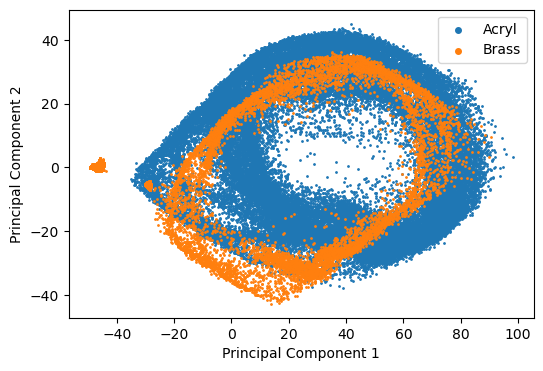

In [102]:
data_pca = compute_PCA(X_train)
plot_PCA(data_pca, Y_train)

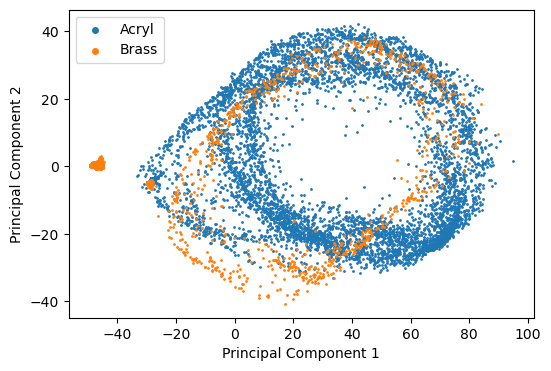

In [103]:
data_pca = compute_PCA(X_test)
plot_PCA(data_pca, Y_test)

In [104]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(111780, 64, 64, 1) (12420, 64, 64, 1) (111780,) (12420,)


In [110]:
def material_classificator_model_CNN(input_shape=(64, 64, 1), latent_dim=1, kernel=3):
    # optional aditional layer
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    mapper_input = tf.keras.layers.Input(shape=input_shape)
    # normalize input data
    # x = Xscaler(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return tf.keras.Model(mapper_input, mapper_output)


material_classificator_CNN = material_classificator_model_CNN()
material_classificator_CNN.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 4, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 1, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 1, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217 (16.47 KB)

 Trainable params: 4,217 (16.47 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
material_classificator_CNN.compile(tf.optimizers.Adam(learning_rate=0.005), loss="mse")

In [113]:
if datagenerator:
    classificator_history_CNN = material_classificator_CNN.fit(
        training_generator, epochs=50, batch_size=128
    )
else:
    classificator_history_CNN = material_classificator_CNN.fit(
        X_train, Y_train, epochs=20, batch_size=params["batch_size"],
    )

Epoch 1/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0437
Epoch 2/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0018
Epoch 3/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0012
Epoch 4/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0011
Epoch 5/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 8.5329e-04
Epoch 6/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 8.7600e-04
Epoch 7/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 8.3300e-04
Epoch 8/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 7.8374e-04
Epoch 9/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 7.8411e-04
Epoch 10/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 7.9636e-04
Epoch 11/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 6.6456e-04
Epoch 12/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 7.4868e-04
Epoch 13/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 7.2603e-04
Epoch 14/20
874/874 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 8.0383e-04


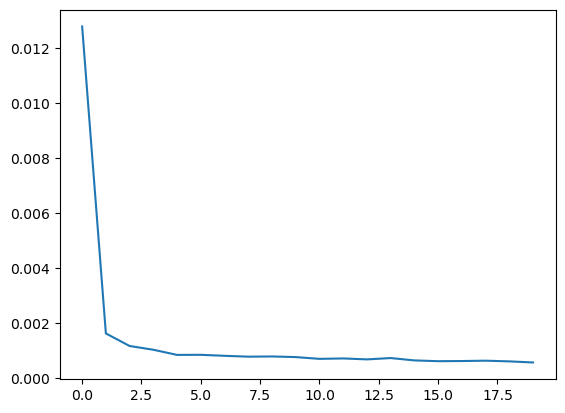

In [117]:
plt.plot(classificator_history_CNN.history["loss"])

In [118]:
Y_pred = np.concatenate(np.round(material_classificator_CNN.predict(X_test)))

389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
m_i = len(glob.glob("models/mapper_*"))
s_path = f"models/mapper_{m_i}"

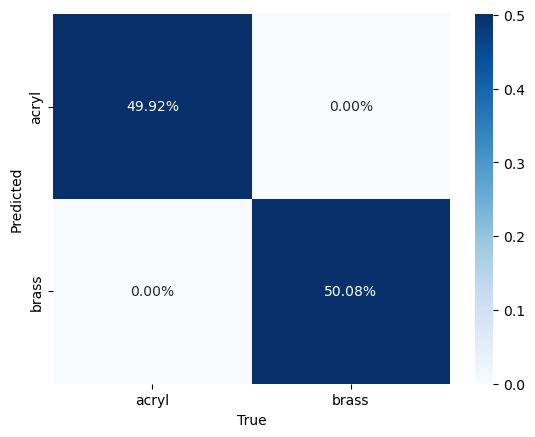

In [120]:
plot_confusion_matrix(Y_test, Y_pred, s_path)

In [119]:
os.mkdir(s_path)
material_classificator_CNN.save(f"{s_path}/model.keras")
np.savez(s_path+"/test_data.npz", X_test=X_test, Y_test=Y_test, params=params)

## Mapper $\Xi$

Loat the VAE model and train the two required mapper.

In [4]:
vae = vae_model()
vae.load_weights("models/vae.weights.h5")
vae.summary()

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ VAE_encoder (Functional)        │ ?                      │         6,935 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VAE_decoder (Functional)        │ ?                      │         9,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,354 (63.88 KB)

 Trainable params: 16,292 (63.64 KB)

 Non-trainable params: 62 (248.00 B)

In [7]:
params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "supervised": "material",  # "diameter" or "material"
    "batch_size": 128,
    "shuffle": True,
}

idx = np.arange(0, len(os.listdir(params["path"])))
np.random.shuffle(idx)

training_generator = DataGenerator(idx[:100_000], **params)

In [ ]:
X, Y = training_generator[0]

In [ ]:
print(X.shape, Y.shape)

## *i)* DNN

In [ ]:
def mapper_model(input_shape=(4_096,), latent_dim=8):
    # hyperparameter tuning
    # dropout, layer, activation function,tunner structures

    mapper_inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Dense(128, activation="relu")(mapper_inputs)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dense(16, activation="relu")(x)
    x = tf.keras.layers.Dense(latent_dim, activation="relu")(x)

    return tf.keras.Model(mapper_inputs, x)


mapper = mapper_model()
mapper.summary()

In [ ]:
mapper.compile(Adam(), loss="mse")

In [ ]:
history = mapper.fit(u, z, epochs=500, batch_size=128)

### *ii)* CNN

In [ ]:
Xscaler = tf.keras.layers.Normalization(axis=2)


def model(input_shape=(64, 64, 1), latent_dim=3, kernel=9):
    mapper_input = tf.keras.layers.Input(shape=input_shape)

    # normalize input data
    x = Xscaler(mapper_input)

    # convolutional layers
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Activation("elu")(x)
    # x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2, 4))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return tf.keras.Model(mapper_input, mapper_output)

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model = model(latent_dim=1, kernel=5)
model.compile(optimizer=opt, loss="mse")

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 64, 64, 1)      │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 16, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 4, 8)       │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 1, 16)       │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 1, 16)       │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,642 (45.48 KB)

 Trainable params: 11,513 (44.97 KB)

 Non-trainable params: 129 (520.00 B)

In [ ]:
# es = tf.keras.callback.EarlyStopping(
#    monitor="val_loss", mode="min", patience=10, restore_best_weights=True
# )
# Xscaler.adapt(X)

history = model.fit(training_generator, batch_size=128, epochs=10)

Epoch 1/10


/home/jath/.conda/envs/TF2_12/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-05 11:44:29.555552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-04-05 11:44:48.093369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/781 ━━━━━━━━━━━━━━━━━━━━ 8:13:41 38s/step - loss: 0.5144

2024-04-05 11:44:52.602850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


357/781 ━━━━━━━━━━━━━━━━━━━━ 40:06 6s/step - loss: 0.1372

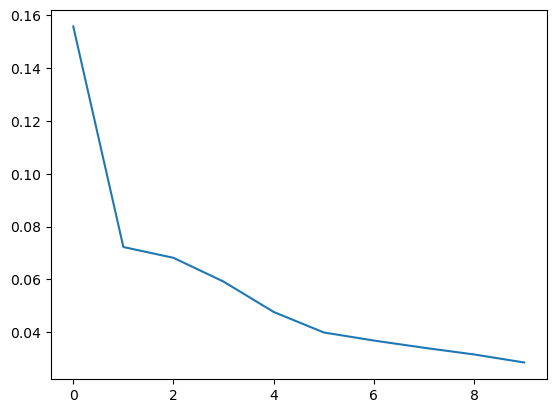

In [9]:
plt.plot(history.history["loss"])

In [11]:
model.save_weights("models/material_mapper.weights.h5")

## *iii)* Performance test

In [ ]:
training_generator = DataGenerator(idx[10_000:20_000], **params)